<a href="https://colab.research.google.com/github/rodya-basmanov/DLS_course/blob/main/hw_6_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Шаг 1. Загрузка и подготовка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>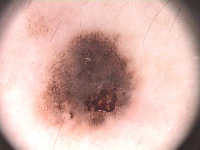</td><td>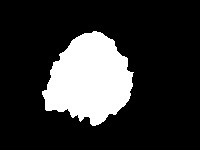</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!gdown 1Pqzj11Oa4rQZjfUz5KuTRgPA8dJJTqNM

Downloading...
From (original): https://drive.google.com/uc?id=1Pqzj11Oa4rQZjfUz5KuTRgPA8dJJTqNM
From (redirected): https://drive.google.com/uc?id=1Pqzj11Oa4rQZjfUz5KuTRgPA8dJJTqNM&confirm=t&uuid=6d775a61-e851-4897-9a42-baf2e8d1020b
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 140MB/s]


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

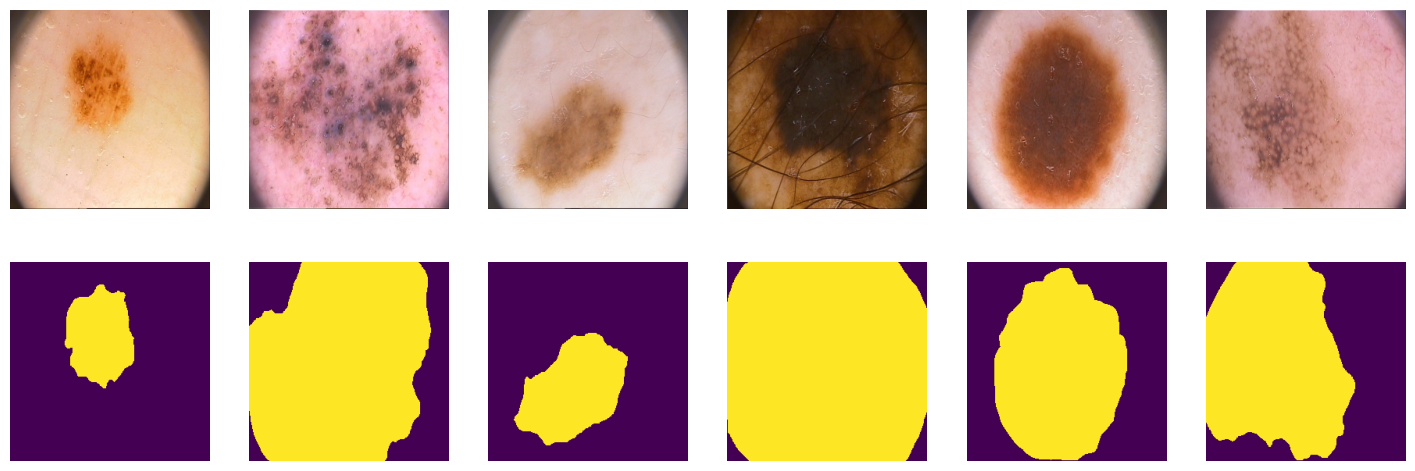

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Шаг 2. Метрика качества модели

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.5 MB/s eta 0:00:00


In [ ]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Задания: Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## Шаг 3. Loss функция - BCE [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:** `  z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
= z * -log(1 / (1 + exp(-x))) + (1 - z) * -log(exp(-x) / (1 + exp(-x)))
= z * log(1 + exp(-x)) + (1 - z) * (-log(exp(-x)) + log(1 + exp(-x)))
= z * log(1 + exp(-x)) + (1 - z) * (x + log(1 + exp(-x))
= (1 - z) * x + log(1 + exp(-x))
= x - x * z + log(1 + exp(-x))`

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
def bce_loss(y_pred, y_real):
  loss = y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred))
  return loss.sum()

def bce_true(y_pred, y_real):
  loss = y_real * -torch.log(1 / (1 + torch.exp(-y_pred))) + (1 - y_real) * -torch.log(torch.exp(-y_pred) / (1 + torch.exp(-y_pred)))
  return loss.sum()

Проверим корректность работы на простом примере

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss             = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный                = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch              = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch  = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss             = 6.536375045776367
BCE loss честно посчитанный                = 6.536375045776367
BCE loss from torch bce_torch              = 6.536375045776367
BCE loss from torch with logits bce_torch  = 6.536375045776367


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss            = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный               = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch             = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss            = 16.5496883392334
BCE loss честно посчитанный               = 16.5496883392334
BCE loss from torch bce_torch             = 16.5496883392334
BCE loss from torch with logits bce_torch = 16.5496883392334


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 4.54MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 5.04MB/s]
Download completed


In [ ]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

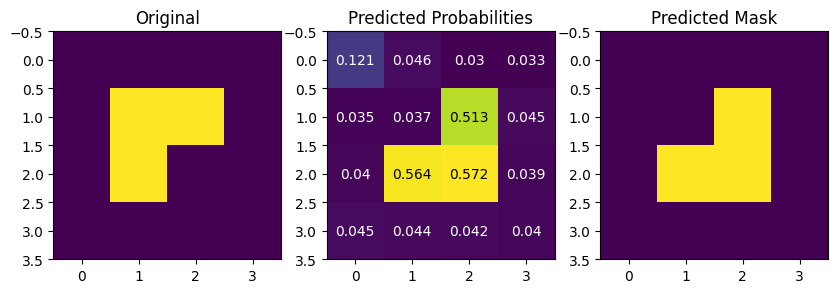

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## Шаг 4. Модель SegNet [2 балла]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки. Для этого скачаем и изучим feature extractor VGG-16, который лежит в основе SegNet.

In [ ]:
model_vgg16 = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 76.6MB/s]


In [ ]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Feature extractor VGG-16 состоит из 5 блоков:
- два блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d
- три блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

В первом блоке - на входе три канала (по числу каналов в изображениях), которые конволюционный слой преобразует в 64 канала.

Во втором, третьем и четвертом блоках первый конволюционный слой удваивает количество каналов, а последующие конволюционные слои не меняют количество каналов.

В последнем блоке число каналов от слоя к слою не меняется.

Теперь напишем код одного блока энкодера нашей модели SegNet.  

In [ ]:
# Параметрами блока будут:
# - количество каналов на входе
# - количество каналов на выходе
# - глубина блока (2 или 3, по количеству конволюционных слоев)
# - kernel_size и padding
#
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1):
        super(EncoderBlock, self).__init__() # инициируем экземляр класса, наследующего от nn.Module
        self.layers = nn.ModuleList() # в self.layers будем добавлять слои блока
        # дальше реализуем то, что на картинке выше обозначено Conv + Batch Normalization + ReLU
        self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU(inplace=True))

        # цикл for помогает использовать один код для блоков как с глубиной 2, так и с глубиной 3
        for i in range(depth-1):
            self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) #добавляем MaxPool с индексами для последующего Unpooling

    # Обратите внимание: на вход метод forward() получает карту признаков (х),
    # а возвращает карту признаков и индексы для последующего Unpooling
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, indices = self.maxpooling(x)
        return x, indices


По аналогии напишите код одного блока декодера.

К карте признаков на входе каждого блока примеяется nn.MaxUnpool2d с индексами из симметричного блока энкодера. Затем повторяется связка Conv + Batch Normalization + ReLU. Количество каналов меняется зеркально блокам энкодера:
- в первом блоке декодера количество каналов не меняется
- во 2-4 блоках декодера количество каналов уменьшается в 2 раза после прохождения последнего конволюционного слоя
- на выходе из последнего блока декодера 1 канал

Обратите внимание, что после последней конволюции последнего блока декодера не применяется батч-нормализация и функция активации.

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1, is_last=False):
        super(DecoderBlock, self).__init__() # инициируем экземляр класса, наследующего от nn.Module

        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.layers = nn.ModuleList() # в self.layers будем добавлять слои блока

        # дальше реализуем то, что на картинке выше обозначено Conv + Batch Normalization + ReLU
        self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU(inplace=True))

        for i in range(depth-2):
            self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

        final_out_channels = 1 if is_last else out_channels
        self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = final_out_channels, kernel_size = kernel_size, padding = padding))

        if not is_last:
            self.layers.append(nn.BatchNorm2d(final_out_channels))
            self.layers.append(nn.ReLU(inplace=True))


    def forward(self, x, indices):
        x = self.unpool(x, indices)
        for layer in self.layers:
            x = layer(x)

        return x

Соединим блоки энкодера и декодера в модель SegNet:

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels = 1, num_features = 64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.encoder0 = EncoderBlock(in_channels, num_features, depth=2)
        self.encoder1 = EncoderBlock(num_features, num_features * 2, depth=2)
        self.encoder2 = EncoderBlock(num_features * 2, num_features * 4, depth=3)
        self.encoder3 = EncoderBlock(num_features * 4, num_features * 8, depth=3)

        # Encoder bottleneck - количество каналов на входе и на выходе одинаково
        self.encoder4 = EncoderBlock(num_features * 8, num_features * 8, depth=3)

        # Decoder bottleneck
        self.decoder4 = DecoderBlock(num_features * 8, num_features * 8, depth=3)

        # Decoder
        self.decoder3 = DecoderBlock(num_features * 8, num_features * 4, depth=3)
        self.decoder2 = DecoderBlock(num_features * 4, num_features * 2, depth=3)
        self.decoder1 = DecoderBlock(num_features * 2, num_features, depth=2)
        self.decoder0 = DecoderBlock(num_features, num_features, depth=2, is_last=True)

    def forward(self, x):
        # encoder
        x, indices0 = self.encoder0(x)
        x, indices1 = self.encoder1(x)
        x, indices2 = self.encoder2(x)
        x, indices3 = self.encoder3(x)
        x, indices4 = self.encoder4(x)
        # decoder
        x = self.decoder4(x, indices4)
        x = self.decoder3(x, indices3)
        x = self.decoder2(x, indices2)
        x = self.decoder1(x, indices1)
        output = self.decoder0(x, indices0)
        return output  # no activation

## Шаг 5. Тренировка модели [1 балл]

Напишите функции для обучения модели.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train_one_epoch(model, optimizer, criterion, train_dataloader, device):
  model.train()

  avg_loss = 0

  for X_batch, Y_batch in tqdm(train_dataloader):
    X_batch = X_batch.to(device)
    Y_batch = Y_batch.to(device)

    Y_pred = model(X_batch)
    loss = criterion(Y_pred, Y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_loss += loss.item() / len(train_dataloader)

  return model, avg_loss

def val_one_epoch(model, criterion, val_dataloader, device):
  iou_score = JaccardIndex(threshold=0.5, task="binary").to(device)
  model.eval()

  avg_loss = 0
  avg_iou = 0
  with torch.no_grad():
    for X_batch, Y_batch in tqdm(valid_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)
        iou = iou_score(Y_pred, Y_batch)
        loss = criterion(Y_pred, Y_batch.float())
        avg_loss += loss.item()
        avg_iou += iou.item()

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)
  return model, avg_loss, avg_iou

In [ ]:
import os

def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path):
  os.makedirs(ckpt_path, exist_ok=True)
  total_train_loss = []
  total_val_loss = []
  total_val_iou = []

  best_val_loss = float('inf')
  best_val_iou = 0

  for epoch in tqdm(range(epochs)):

      model, train_loss = train_one_epoch(model, optimizer, criterion, train_dataloader, device)
      model, val_loss, val_iou = val_one_epoch(model, criterion, valid_dataloader, device)
      print(f'Epoch {epoch}: train loss = {train_loss}')
      print(f'Epoch {epoch}: val loss = {val_loss}')
      print(f'Epoch {epoch}: val iou = {val_iou}')

      total_train_loss.append(train_loss)
      total_val_loss.append(val_loss)
      total_val_iou.append(val_iou)
      if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_best_val_loss.pt')

      torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_val_iou.pt')

  statistics = {'train loss': total_train_loss,
                'val_loss': total_val_loss,
                'val_iou': total_val_iou}

  return model, statistics

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [ ]:
model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
epochs = 20
ckpt_path = '/content/checkpoints'

model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.6696024388074875
Epoch 0: val loss = 0.6862590610980988
Epoch 0: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.5905328094959259
Epoch 1: val loss = 0.6662904918193817
Epoch 1: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.49745773524045944
Epoch 2: val loss = 0.6375974416732788
Epoch 2: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.4066239073872566
Epoch 3: val loss = 0.6134154796600342
Epoch 3: val iou = 0.07011428475379944


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.34172843396663666
Epoch 4: val loss = 1.2241905331611633
Epoch 4: val iou = 0.13261752482503653


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.31873854994773865
Epoch 5: val loss = 1.0702779293060303
Epoch 5: val iou = 0.1496720314025879


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.31207534670829773
Epoch 6: val loss = 0.9201138913631439
Epoch 6: val iou = 0.2706586495041847


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.2430809922516346
Epoch 7: val loss = 0.6581479907035828
Epoch 7: val iou = 0.3529573678970337


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.22734484821558
Epoch 8: val loss = 0.5173579007387161
Epoch 8: val iou = 0.47287437319755554


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.22861159965395927
Epoch 9: val loss = 0.45535723865032196
Epoch 9: val iou = 0.5345712602138519


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.2133038192987442
Epoch 10: val loss = 0.44958002865314484
Epoch 10: val iou = 0.6115615367889404


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.222088772803545
Epoch 11: val loss = 0.3418648764491081
Epoch 11: val iou = 0.6588904857635498


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.19263366609811783
Epoch 12: val loss = 0.33825506269931793
Epoch 12: val iou = 0.6513862907886505


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.22649337723851204
Epoch 13: val loss = 0.22745735198259354
Epoch 13: val iou = 0.7501677870750427


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.20924169942736626
Epoch 14: val loss = 0.2908535897731781
Epoch 14: val iou = 0.6607036590576172


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.2487053945660591
Epoch 15: val loss = 0.2807408273220062
Epoch 15: val iou = 0.6854250729084015


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.21206292510032654
Epoch 16: val loss = 0.29635339975357056
Epoch 16: val iou = 0.671319305896759


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.18398136273026466
Epoch 17: val loss = 0.23975498229265213
Epoch 17: val iou = 0.7563990354537964


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.19515971094369888
Epoch 18: val loss = 0.21712569147348404
Epoch 18: val iou = 0.7798581123352051


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.19272926822304726
Epoch 19: val loss = 0.25889240205287933
Epoch 19: val iou = 0.7468914985656738


## Шаг 6. Инференс [1 балл]

После обучения модели напишите функцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
def test(model, test_dataloader, device, ckpt_path, ckpt_name):

    model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))
    model.to(device)
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in test_dataloader:
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device).float()

          Y_pred = model(X_batch.to(device))
          avg_iou += iou_score(torch.sigmoid(Y_pred), Y_batch) # , threshold = 0.5)
      avg_iou = avg_iou / len(test_dataloader)

    return avg_iou

In [ ]:
test(model, test_dataloader, device, ckpt_path, 'epoch_18_val_iou.pt')

tensor(0.7265, device='cuda:0')

# Задания: Мир других лоссов!

## Пробуем другие функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > threshold).float()

    tp = torch.sum(pred_mask*labels)
    fp = torch.sum(pred_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    score = (2 * tp + eps) / (2 * tp + fp + fn + eps)

    return score

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


tensor(0.3158, device='cuda:0')

In [ ]:
'''
если вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():

from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)

'''

In [ ]:
assert dice((dummpy_sample['logits'].sigmoid()>0.5).to(int), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    prob_mask = logits.sigmoid()

    tp = torch.sum(prob_mask*labels)
    fp = torch.sum(prob_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    score = (2 * tp + eps) / (2 * tp + fp + fn + eps)

    loss = 1 - score

    return loss

Проверка на корректность:

In [ ]:
# проверьте, что у вас установлена библиотека
!pip install segmentation-models-pytorch

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, gamma=2, eps=1e-8):
    p = torch.sigmoid(y_pred)

    loss = -1 * (1 - (p * y_real + (1 - p) * (1 - y_real))) ** gamma * (y_real * torch.log(p + eps) + (1 - y_real) * torch.log(1 - p + eps))

    return loss.sum()

Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [ ]:
assert torch.allclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'),
                      focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0),
                      rtol=1e-5,
                      atol=1e-8)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [ ]:
def tversky_loss(y_pred, y_true, alpha=0.7, beta=0.3, smooth=1e-6):
    """
    Tversky Loss для бинарной сегментации

    Args:
        y_pred: предсказания модели (логиты)
        y_true: истинные маски
        alpha: вес для False Negatives
        beta: вес для False Positives
        smooth: для численной стабильности
    """
    y_pred_prob = torch.sigmoid(y_pred)

    tp = torch.sum(y_pred_prob * y_true)
    fp = torch.sum(y_pred_prob * (1 - y_true))
    fn = torch.sum((1 - y_pred_prob) * y_true)

    tversky_index = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)

    # Tversky Loss
    loss = 1 - tversky_index

    return loss

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [ ]:
model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = dice_loss
epochs = 20
ckpt_path = '/content/checkpoints'

model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.5669671893119812
Epoch 0: val loss = 0.5755435526371002
Epoch 0: val iou = 0.04009331949055195


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.46651436388492584
Epoch 1: val loss = 0.5827770233154297
Epoch 1: val iou = 0.007444939783454174


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.3759598881006241
Epoch 2: val loss = 0.4675205647945404
Epoch 2: val iou = 0.5061679184436798


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.3191056102514267
Epoch 3: val loss = 0.4318660795688629
Epoch 3: val iou = 0.4366685152053833


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.26497821509838104
Epoch 4: val loss = 0.4136131703853607
Epoch 4: val iou = 0.4440903216600418


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.2537294924259186
Epoch 5: val loss = 0.3567797541618347
Epoch 5: val iou = 0.5084261000156403


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.2132890224456787
Epoch 6: val loss = 0.2422770857810974
Epoch 6: val iou = 0.6410673558712006


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.200345978140831
Epoch 7: val loss = 0.21432161331176758
Epoch 7: val iou = 0.6769883334636688


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.1571654975414276
Epoch 8: val loss = 0.19827958941459656
Epoch 8: val iou = 0.6858213543891907


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.15467104315757751
Epoch 9: val loss = 0.15852180123329163
Epoch 9: val iou = 0.7434646487236023


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.1638067662715912
Epoch 10: val loss = 0.1440669298171997
Epoch 10: val iou = 0.760957270860672


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.16544419527053833
Epoch 11: val loss = 0.15457743406295776
Epoch 11: val iou = 0.7419005632400513


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.16290752589702606
Epoch 12: val loss = 0.13023632764816284
Epoch 12: val iou = 0.7837168276309967


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.13329939544200897
Epoch 13: val loss = 0.1516355276107788
Epoch 13: val iou = 0.7484553158283234


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.13647980988025665
Epoch 14: val loss = 0.13361597061157227
Epoch 14: val iou = 0.7768464088439941


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.12567546963691711
Epoch 15: val loss = 0.13064968585968018
Epoch 15: val iou = 0.7767108082771301


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.12835322320461273
Epoch 16: val loss = 0.12944406270980835
Epoch 16: val iou = 0.7778260111808777


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.1215590387582779
Epoch 17: val loss = 0.1294098198413849
Epoch 17: val iou = 0.7764560580253601


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.11389806866645813
Epoch 18: val loss = 0.13005009293556213
Epoch 18: val iou = 0.7758990228176117


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.11821354925632477
Epoch 19: val loss = 0.12800076603889465
Epoch 19: val iou = 0.7783954441547394


In [ ]:
model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = focal_loss
epochs = 20
ckpt_path = '/content/checkpoints'

model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 20219.0390625
Epoch 0: val loss = 608577.6875
Epoch 0: val iou = 0.24778053909540176


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = -24332783.513671875
Epoch 1: val loss = 629179.6875
Epoch 1: val iou = 0.04475625604391098


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = -38190379.5
Epoch 2: val loss = -856286925160448.0
Epoch 2: val iou = 0.3710848391056061


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = -136717660.0
Epoch 3: val loss = -57537210613760.0
Epoch 3: val iou = 0.37107983231544495


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = -454081707.0
Epoch 4: val loss = -3035100245655552.0
Epoch 4: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = -578005022.0
Epoch 5: val loss = -9937647413755904.0
Epoch 5: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = -2161363200.0
Epoch 6: val loss = -1063959834656768.0
Epoch 6: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = -5164968384.0
Epoch 7: val loss = -6441562959511552.0
Epoch 7: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = -16974885888.0
Epoch 8: val loss = -2756115712.0
Epoch 8: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = -12239222144.0
Epoch 9: val loss = -1003809195.0
Epoch 9: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = -36469945344.0
Epoch 10: val loss = -373648474112.0
Epoch 10: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = -35001158112.0
Epoch 11: val loss = -1.7665156035536486e+17
Epoch 11: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = -56233209856.0
Epoch 12: val loss = -3.7298383510506045e+18
Epoch 12: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = -150456717312.0
Epoch 13: val loss = -9020669815685120.0
Epoch 13: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = -520702861312.0
Epoch 14: val loss = -171675709952.0
Epoch 14: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = -794962422784.0
Epoch 15: val loss = -232620856.0
Epoch 15: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = -2107533885440.0
Epoch 16: val loss = -190742160.0
Epoch 16: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = -570984583168.0
Epoch 17: val loss = -256538936.0
Epoch 17: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = -10246701568.0
Epoch 18: val loss = -1327276544.0
Epoch 18: val iou = 0.37106049060821533


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = -19451105280.0
Epoch 19: val loss = -11667355648.0
Epoch 19: val iou = 0.37106049060821533


ну я как бы не знаю, что с этим лоссом делать :(
  строго не судите.

In [ ]:
model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = bce_loss
epochs = 20
ckpt_path = '/content/checkpoints'

model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 1203775.4375
Epoch 0: val loss = 1125990.5625
Epoch 0: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 1028786.203125
Epoch 1: val loss = 1110699.0625
Epoch 1: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 943092.265625
Epoch 2: val loss = 1088535.875
Epoch 2: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 829644.21875
Epoch 3: val loss = 1347020.625
Epoch 3: val iou = 0.12830481957644224


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 710526.84375
Epoch 4: val loss = 1192388.3125
Epoch 4: val iou = 0.007110338658094406


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 572845.8984375
Epoch 5: val loss = 1356916.3125
Epoch 5: val iou = 0.03214848227798939


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 461167.609375
Epoch 6: val loss = 1452413.1875
Epoch 6: val iou = 0.07914950139820576


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 531675.90625
Epoch 7: val loss = 1095272.1875
Epoch 7: val iou = 0.258839875459671


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 422554.7421875
Epoch 8: val loss = 1464010.9375
Epoch 8: val iou = 0.012603626120835543


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 440588.0859375
Epoch 9: val loss = 1159849.125
Epoch 9: val iou = 0.08764734119176865


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 426147.03125
Epoch 10: val loss = 918227.78125
Epoch 10: val iou = 0.2688777595758438


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 388128.8046875
Epoch 11: val loss = 1234391.25
Epoch 11: val iou = 0.01816270686686039


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 388355.6484375
Epoch 12: val loss = 794720.90625
Epoch 12: val iou = 0.3702983558177948


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 359139.7109375
Epoch 13: val loss = 936814.28125
Epoch 13: val iou = 0.32627810537815094


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 458868.640625
Epoch 14: val loss = 734617.875
Epoch 14: val iou = 0.5428459942340851


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 421466.671875
Epoch 15: val loss = 597288.125
Epoch 15: val iou = 0.5955187678337097


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 383437.53125
Epoch 16: val loss = 988731.8125
Epoch 16: val iou = 0.09632249549031258


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 362496.09375
Epoch 17: val loss = 715644.0
Epoch 17: val iou = 0.4824017584323883


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 363622.0078125
Epoch 18: val loss = 469596.59375
Epoch 18: val iou = 0.7196740508079529


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 310836.6484375
Epoch 19: val loss = 397904.03125
Epoch 19: val iou = 0.748807281255722


Скорость сходимости: Dice Loss демонстрирует наиболее быструю сходимость - модель достигает IoU > 0.76 уже к 10-й эпохе, тогда как Tversky Loss показывает сравнимые результаты только к 11-й эпохе. Focal Loss вообще не сходится из-за проблем реализации.

Лучшая метрика: Dice Loss обеспечивает максимальное качество сегментации с финальным IoU = 0.778, что превосходит результат Tversky Loss (IoU = 0.742) на 3.6 процентных пункта.

Вывод: Dice Loss является оптимальным выбором - он сочетает быстрое обучение с высочайшим конечным качеством, что делает его наиболее эффективным для задачи сегментации медицинских изображений.

# Задание: Новая модель!

## Модель U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

В оригинальной статье авторы не использовали padding внутри модели (это видно по тому, что размеры карты признаков уменьшаются на 2 каждый раз при движении от слоя к слою). При этом размеры входных изображений авторы единоразово увеличили при помощи mirror padding.

В этом домашнем задании вы можете применить альтернативный подход - сохранять размеры карт признаков при помощью padding = 1 во внутренних слоях.  

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

Для реализации UNet вы можете написать классы блоков энкодера и декодера отдельно, как мы сделали при реализации SegNet.

In [ ]:
class UNetEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(UNetEncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        skip_connection = x
        x = self.pool(x)
        return x, skip_connection

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(UNetDecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.bn_up = nn.BatchNorm2d(in_channels // 2)

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, skip_connection):
        x = self.bn_up(self.upconv(x))
        x = torch.cat([x, skip_connection], dim=1)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x

class UNet(nn.Module):
    def __init__(self, n_class=1):
        super(UNet, self).__init__()

        self.enc1 = UNetEncoderBlock(in_channels=3, out_channels=64)
        self.enc2 = UNetEncoderBlock(in_channels=64, out_channels=128)
        self.enc3 = UNetEncoderBlock(in_channels=128, out_channels=256)
        self.enc4 = UNetEncoderBlock(in_channels=256, out_channels=512)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        self.dec4 = UNetDecoderBlock(in_channels=1024, out_channels=512) # 1024 -> 512 -> 512
        self.dec3 = UNetDecoderBlock(in_channels=512, out_channels=256) # 512 -> 256 -> 256
        self.dec2 = UNetDecoderBlock(in_channels=256, out_channels=128) # 256 -> 128 -> 128
        self.dec1 = UNetDecoderBlock(in_channels=128, out_channels=64)  # 128 -> 64 -> 64


        self.final_conv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        x, skip1 = self.enc1(x) # x: [B, 64, H/2, W/2], skip1: [B, 64, H, W]
        x, skip2 = self.enc2(x) # x: [B, 128, H/4, W/4], skip2: [B, 128, H/2, W/2]
        x, skip3 = self.enc3(x) # x: [B, 256, H/8, W/8], skip3: [B, 256, H/4, W/4]
        x, skip4 = self.enc4(x) # x: [B, 512, H/16, W/16], skip4: [B, 512, H/8, W/8]

        x = self.bottleneck(x) # x: [B, 1024, H/16, W/16]

        x = self.dec4(x, skip4) # x: [B, 512, H/8, W/8]
        x = self.dec3(x, skip3) # x: [B, 256, H/4, W/4]
        x = self.dec2(x, skip2) # x: [B, 128, H/2, W/2]
        x = self.dec1(x, skip1) # x: [B, 64, H, W]

        output = self.final_conv(x)

        return output

In [ ]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [ ]:
model = unet_model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = dice_loss
epochs = 20
ckpt_path = '/content/checkpoints'

model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.45138242840766907
Epoch 0: val loss = 0.5892854034900665
Epoch 0: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.34740428626537323
Epoch 1: val loss = 0.3324067294597626
Epoch 1: val iou = 0.5748008489608765


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.2988429218530655
Epoch 2: val loss = 0.38627228140830994
Epoch 2: val iou = 0.4538484811782837


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.27493856847286224
Epoch 3: val loss = 0.6075229942798615
Epoch 3: val iou = 0.17128653451800346


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.26317502558231354
Epoch 4: val loss = 0.47640448808670044
Epoch 4: val iou = 0.33104120194911957


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.2502153515815735
Epoch 5: val loss = 0.5790872871875763
Epoch 5: val iou = 0.2645593211054802


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.23363599181175232
Epoch 6: val loss = 0.3498512804508209
Epoch 6: val iou = 0.5432101190090179


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.22120964527130127
Epoch 7: val loss = 0.28142356872558594
Epoch 7: val iou = 0.6660130620002747


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.21244147419929504
Epoch 8: val loss = 0.2238253355026245
Epoch 8: val iou = 0.7398257255554199


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.2130403369665146
Epoch 9: val loss = 0.20020383596420288
Epoch 9: val iou = 0.7594084143638611


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.1917375773191452
Epoch 10: val loss = 0.19229361414909363
Epoch 10: val iou = 0.7621131837368011


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.20846576988697052
Epoch 11: val loss = 0.19491326808929443
Epoch 11: val iou = 0.748510330915451


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.19336360692977905
Epoch 12: val loss = 0.15201783180236816
Epoch 12: val iou = 0.8006166517734528


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.1926906555891037
Epoch 13: val loss = 0.1696542501449585
Epoch 13: val iou = 0.7845815420150757


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.17131666839122772
Epoch 14: val loss = 0.25059542059898376
Epoch 14: val iou = 0.6627697348594666


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.1638604700565338
Epoch 15: val loss = 0.15285244584083557
Epoch 15: val iou = 0.7981719970703125


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.1522042602300644
Epoch 16: val loss = 0.15356141328811646
Epoch 16: val iou = 0.7771956324577332


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.16830337047576904
Epoch 17: val loss = 0.14294278621673584
Epoch 17: val iou = 0.791748583316803


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.16153603792190552
Epoch 18: val loss = 0.14651274681091309
Epoch 18: val iou = 0.7851861119270325


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.1419997662305832
Epoch 19: val loss = 0.12612006068229675
Epoch 19: val iou = 0.8195244669914246


In [ ]:
model = unet_model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = focal_loss
epochs = 20
ckpt_path = '/content/checkpoints'

model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = -64047638.75
Epoch 0: val loss = -20262480904192.0
Epoch 0: val iou = 0.37824034690856934


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = -154152136.0
Epoch 1: val loss = -15347129253888.0
Epoch 1: val iou = 0.4012172520160675


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = -70515463.0390625
Epoch 2: val loss = 1953428.75
Epoch 2: val iou = 0.09325091540813446


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = -101246275.0
Epoch 3: val loss = -9682492.5
Epoch 3: val iou = 0.541714996099472


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = -189028384.0
Epoch 4: val loss = -42132684.5
Epoch 4: val iou = 0.2964669167995453


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = -337698892.0
Epoch 5: val loss = -1993144000.0
Epoch 5: val iou = 0.31312301754951477


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = -577411896.0
Epoch 6: val loss = -43423295488.0
Epoch 6: val iou = 0.3762039691209793


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = -669654976.0
Epoch 7: val loss = -9114137600.0
Epoch 7: val iou = 0.36589810252189636


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = -1016854864.0
Epoch 8: val loss = -44865996800.0
Epoch 8: val iou = 0.15076188743114471


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = -1068164320.0
Epoch 9: val loss = -3635147008.0
Epoch 9: val iou = 0.324137881398201


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = -1935890656.0
Epoch 10: val loss = -2223793920.0
Epoch 10: val iou = 0.13397735729813576


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = -3214700096.0
Epoch 11: val loss = -41603971072.0
Epoch 11: val iou = 0.5032186359167099


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = -1321583104.0
Epoch 12: val loss = -89203542016.0
Epoch 12: val iou = 0.4732854813337326


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = -2107759616.0
Epoch 13: val loss = -1094731726848.0
Epoch 13: val iou = 0.39106321334838867


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = -1295499184.0
Epoch 14: val loss = -2063660744704.0
Epoch 14: val iou = 0.46689946949481964


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = -1970306208.0
Epoch 15: val loss = -295667433472.0
Epoch 15: val iou = 0.5334718227386475


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = -2845737856.0
Epoch 16: val loss = -336245850112.0
Epoch 16: val iou = 0.5376022756099701


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = -2011985424.0
Epoch 17: val loss = -8931881517056.0
Epoch 17: val iou = 0.45276781916618347


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = -3058148224.0
Epoch 18: val loss = -1201078403072.0
Epoch 18: val iou = 0.42831212282180786


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = -4022473216.0
Epoch 19: val loss = -72351760384.0
Epoch 19: val iou = 0.41007690131664276


In [ ]:
model = unet_model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = bce_loss
epochs = 20
ckpt_path = '/content/checkpoints'

model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 722296.6015625
Epoch 0: val loss = 716223.03125
Epoch 0: val iou = 0.6797308921813965


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 444237.3125
Epoch 1: val loss = 508095.28125
Epoch 1: val iou = 0.7210778892040253


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 400100.109375
Epoch 2: val loss = 447497.65625
Epoch 2: val iou = 0.7526816129684448


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 344006.59375
Epoch 3: val loss = 521083.34375
Epoch 3: val iou = 0.7138391733169556


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 379742.19921875
Epoch 4: val loss = 362694.90625
Epoch 4: val iou = 0.781800776720047


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 318380.296875
Epoch 5: val loss = 354820.65625
Epoch 5: val iou = 0.7995606660842896


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 366646.1953125
Epoch 6: val loss = 341365.90625
Epoch 6: val iou = 0.8019794523715973


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 282016.26953125
Epoch 7: val loss = 372322.703125
Epoch 7: val iou = 0.7861371040344238


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 292937.296875
Epoch 8: val loss = 424285.90625
Epoch 8: val iou = 0.7556571662425995


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 298254.97265625
Epoch 9: val loss = 401442.265625
Epoch 9: val iou = 0.7674242556095123


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 269557.29296875
Epoch 10: val loss = 380164.90625
Epoch 10: val iou = 0.7834498286247253


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 260465.96484375
Epoch 11: val loss = 357366.4375
Epoch 11: val iou = 0.7964111566543579


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 248699.63671875
Epoch 12: val loss = 320269.75
Epoch 12: val iou = 0.8150195479393005


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 256216.84375
Epoch 13: val loss = 329071.734375
Epoch 13: val iou = 0.8084096908569336


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 251783.98828125
Epoch 14: val loss = 359382.109375
Epoch 14: val iou = 0.7943456172943115


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 278528.24609375
Epoch 15: val loss = 319369.0625
Epoch 15: val iou = 0.8190048336982727


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 252130.42578125
Epoch 16: val loss = 325789.2578125
Epoch 16: val iou = 0.8223366141319275


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 253595.3046875
Epoch 17: val loss = 374402.1875
Epoch 17: val iou = 0.8029977381229401


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 226375.9921875
Epoch 18: val loss = 340111.15625
Epoch 18: val iou = 0.8138821721076965


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 237662.58203125
Epoch 19: val loss = 324123.71875
Epoch 19: val iou = 0.8207041919231415


Вывод: 1. U-Net с BCE Loss показывает наилучшую метрику IoU = 0.8207
2. По значениям лоссов лучшие результаты показывает U-Net с Dice Loss, который достиг минимального значения 0.126 на валидации. BCE Loss демонстрирует значительно более высокие абсолютные значения (324,124), но обеспечивает стабильное снижение в течение обучения. SegNet с Dice Loss показывает сравнимые результаты с финальным лоссом 0.128.
3. По скорости обучения U-Net значительно превосходит SegNet в терминах количества эпох - с BCE Loss он достигает IoU > 0.75 уже к 2-й эпохе, тогда как SegNet требует 12 эпох. Однако в абсолютном времени U-Net обучается медленнее (~6.7-8.1 сек/эпоху против ~4.5-5.0 сек у SegNet) из-за более сложной архитектуры. Таким образом, U-Net быстрее сходится, но требует больше вычислительных ресурсов на эпоху.
4.